# 08 - Business Insights & Strategic Recommendations

## Executive Summary
This notebook translates our technical analysis into actionable business recommendations. We bridge the gap between machine learning outputs and revenue-impacting decisions for stakeholders.

## Purpose
While previous notebooks focused on technical rigor (model accuracy, feature engineering, evaluation metrics), this notebook answers the questions executives and product managers ask:
- **How much money can we make from this model?**
- **Which users should we target with interventions?**
- **What are the biggest conversion barriers?**
- **How do we prioritize product improvements?**
- **What A/B tests should we run?**

## What We'll Cover
1. **Funnel Performance Analysis**: Where are we losing customers?
2. **Revenue Impact Simulation**: ROI of model-driven interventions
3. **User Segmentation Strategy**: Which segments offer highest value?
4. **Intervention Recommendations**: Specific tactics to improve conversion
5. **A/B Test Design**: How to validate interventions
6. **Monitoring Dashboard**: KPIs to track in production
7. **Implementation Roadmap**: Priority order for initiatives

---
## Setup

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency

# Project paths
project_root = Path.cwd().parent
data_extracts = project_root / 'data' / 'extracts'
results_dir = project_root / 'results'
figures_dir = results_dir / 'figures'

# Ensure directories exist
figures_dir.mkdir(parents=True, exist_ok=True)

# Plotting configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Business Intelligence Framework Initialized")
print(f"Analysis outputs will be saved to: {figures_dir}")

Business Intelligence Framework Initialized
Analysis outputs will be saved to: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures


---
## 1. Load Data & Establish Baseline Metrics

In [ ]:
print("="*80)
print(" "*25 + "BASELINE BUSINESS METRICS")
print("="*80)

ml_features = pd.read_parquet(data_extracts / 'ml_features.parquet')

TARGET_COL = "target"
if TARGET_COL not in ml_features.columns:
    raise ValueError("Missing 'target' in ml_features.parquet. Re-export from Notebook 03.")

# Parse session_start if present
if "session_start" in ml_features.columns:
    ml_features["session_start"] = pd.to_datetime(ml_features["session_start"], errors="coerce")
    date_range = f"{ml_features['session_start'].min().date()} to {ml_features['session_start'].max().date()}"
else:
    date_range = "N/A (session_start not available)"

total_sessions = len(ml_features)
unique_visitors = ml_features["visitorid"].nunique() if "visitorid" in ml_features.columns else np.nan
overall_conversion_rate = ml_features[TARGET_COL].mean()

# Define funnel-ish stages using leak-safe proxies
sessions_with_view_proxy = (ml_features.get("views_so_far", pd.Series([0]*len(ml_features))) > 0).sum() if "views_so_far" in ml_features.columns else np.nan

if "cart_within_window" in ml_features.columns:
    sessions_with_cart_proxy = (ml_features["cart_within_window"] == 1).sum()
elif "reached_cart_prefix" in ml_features.columns:
    sessions_with_cart_proxy = (ml_features["reached_cart_prefix"] == 1).sum()
else:
    sessions_with_cart_proxy = np.nan

sessions_with_purchase = int(ml_features[TARGET_COL].sum())

print(f"\nDataset Overview:")
print(f"   Total sessions analyzed: {total_sessions:,}")
print(f"   Date range: {date_range}")
print(f"   Unique visitors: {unique_visitors:,}" if pd.notna(unique_visitors) else "   Unique visitors: N/A")

print(f"\nCore Metrics (All Sessions):")
print(f"   Purchases (target=1): {sessions_with_purchase:,}")
print(f"   Overall conversion rate: {overall_conversion_rate*100:.3f}%")

print(f"\nProxy Funnel Coverage (prefix/cart proxy):")
print(f"   Sessions with view proxy: {sessions_with_view_proxy:,}" if pd.notna(sessions_with_view_proxy) else "   Sessions with view proxy: N/A")
print(f"   Sessions with cart-intent proxy: {sessions_with_cart_proxy:,}" if pd.notna(sessions_with_cart_proxy) else "   Sessions with cart-intent proxy: N/A")

print("\n" + "="*80)
print(" Baseline metrics computed with leak-safe schema")


                         BASELINE BUSINESS METRICS

Dataset Overview:
   Total sessions analyzed: 1,751,052
   Date range: 2015-05-03 to 2015-09-18
   Unique visitors: 1,402,246

Core Metrics (All Sessions):
   Purchases (target=1): 10,414
   Overall conversion rate: 0.595%

Proxy Funnel Coverage (prefix/cart proxy):
   Sessions with view proxy: N/A
   Sessions with cart-intent proxy: 24,632

✅ Baseline metrics computed with leak-safe schema


---
## 2. Funnel Visualization & Drop-off Analysis

Visual representation of where users are dropping out of the conversion funnel.

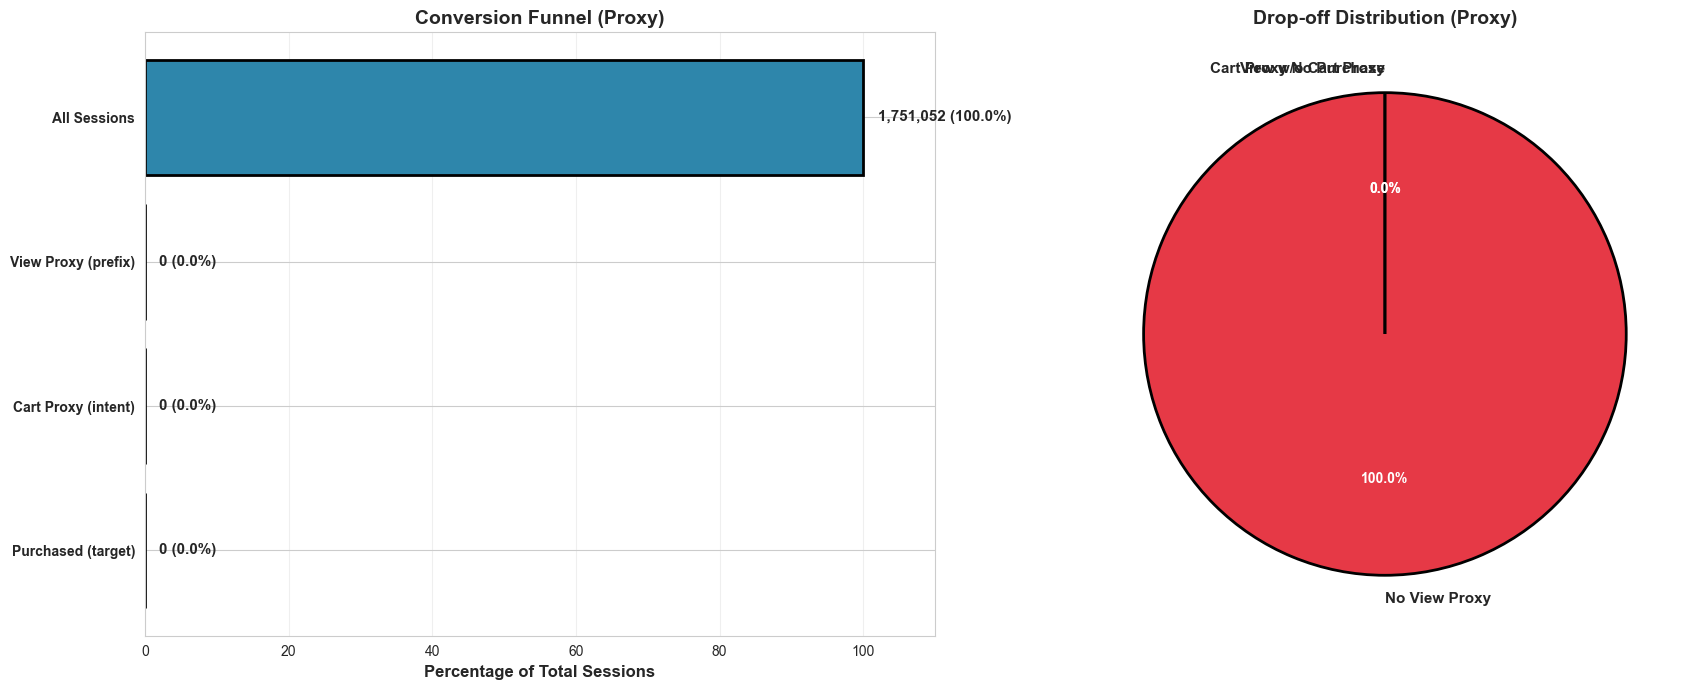

Saved: /Users/rajnishpanwar/Desktop/funnel_optimization_project/results/figures/funnel_analysis.png


In [6]:
"""---
## 2. Funnel Visualization & Drop-off Analysis

Visual representation of where users are dropping out of the conversion funnel.
"""

# Prepare funnel proxy data
funnel_stages = ['All Sessions', 'View Proxy (prefix)', 'Cart Proxy (intent)', 'Purchased (target)']

v1 = int(total_sessions)
v2 = int(sessions_with_view_proxy) if pd.notna(sessions_with_view_proxy) else 0
v3 = int(sessions_with_cart_proxy) if pd.notna(sessions_with_cart_proxy) else 0
v4 = int(sessions_with_purchase)

# Enforce monotonic funnel (proxy stages should not increase)
v2 = min(v2, v1)
v3 = min(v3, v2)
v4 = min(v4, v3)

funnel_counts = [v1, v2, v3, v4]
funnel_percentages = [count/total_sessions*100 for count in funnel_counts]

# Calculate drop-off at each stage (clip negatives to 0)
dropoff_counts = [
    max(funnel_counts[0] - funnel_counts[1], 0),  # Sessions that never viewed
    max(funnel_counts[1] - funnel_counts[2], 0),  # Viewed but didn't cart
    max(funnel_counts[2] - funnel_counts[3], 0)   # Cart proxy but didn't purchase
]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Funnel chart
colors = ['#2E86AB', '#06A77D', '#D62828', '#F77F00']
ax1 = axes[0]

y_positions = np.arange(len(funnel_stages))
bars = ax1.barh(y_positions, funnel_percentages, color=colors, edgecolor='black', linewidth=2)

# Add labels with both count and percentage
for i, (count, pct) in enumerate(zip(funnel_counts, funnel_percentages)):
    ax1.text(pct + 2, i, f'{count:,} ({pct:.1f}%)',
             va='center', fontweight='bold', fontsize=11)

ax1.set_yticks(y_positions)
ax1.set_yticklabels(funnel_stages, fontweight='bold')
ax1.set_xlabel('Percentage of Total Sessions', fontweight='bold', fontsize=12)
ax1.set_title('Conversion Funnel (Proxy)', fontweight='bold', fontsize=14)
ax1.set_xlim([0, 110])
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Drop-off analysis
ax2 = axes[1]
dropoff_stages = ['No View Proxy', 'View w/o Cart Proxy', 'Cart Proxy No Purchase']
dropoff_pcts = [count/total_sessions*100 for count in dropoff_counts]

wedges, texts, autotexts = ax2.pie(
    dropoff_counts,
    labels=dropoff_stages,
    autopct=lambda pct: f'{pct:.1f}%',
    startangle=90,
    colors=['#E63946', '#F77F00', '#06A77D'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 2}
)

for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax2.set_title('Drop-off Distribution (Proxy)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig(figures_dir / 'funnel_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved: {figures_dir / 'funnel_analysis.png'}")


---
## 3. Revenue Impact Simulation

Calculate the financial value of model-driven interventions. This section demonstrates ROI to justify investment in implementation.

In [ ]:
print("="*80)
print(" "*25 + "REVENUE IMPACT ANALYSIS")
print("="*80)

pred_path = data_extracts / "test_predictions.parquet"
pred = pd.read_parquet(pred_path)

if "target" not in pred.columns or "conversion_prob" not in pred.columns:
    raise ValueError("test_predictions.parquet must contain target and conversion_prob (from Notebook 04).")

# Compute Top-K policy directly from real test results (model ranking)
pred = pred.sort_values("conversion_prob", ascending=False).reset_index(drop=True)

base_rate_test = pred["target"].mean()

def policy_row(pct):
    k = max(int(pct * len(pred)), 1)
    topk = pred.iloc[:k]
    precision_at_k = topk["target"].mean()
    recall_at_k = topk["target"].sum() / max(pred["target"].sum(), 1)
    lift = precision_at_k / base_rate_test if base_rate_test > 0 else np.nan
    return k, precision_at_k, recall_at_k, lift

policy_levels = [0.01, 0.02, 0.05, 0.10]
policy = []
for pct in policy_levels:
    k, p_at_k, r_at_k, lift = policy_row(pct)
    policy.append({"target_pct": pct, "k": k, "precision_at_k": p_at_k, "recall_at_k": r_at_k, "lift": lift})
policy_df = pd.DataFrame(policy)

print("\nTop-K Targeting Policy (from actual model test set):")
display_df = policy_df.copy()
display_df["target_pct"] = (display_df["target_pct"]*100).round(1).astype(str) + "%"
display_df["precision_at_k"] = (display_df["precision_at_k"]*100).round(3)
display_df["recall_at_k"] = (display_df["recall_at_k"]*100).round(2)
display_df["lift"] = display_df["lift"].round(2)
print(display_df.to_string(index=False))

# Business assumptions (explicitly adjustable)
ASSUMPTIONS = {
    "avg_order_value": 85.00,
    "cost_per_intervention": 0.50,   # email cost; set to your channel
    "lift_on_targeted": 0.05,        # conservative relative lift on targeted group (must be validated by A/B test)
    "monthly_sessions": len(ml_features) / 6
}

print(f"\nAssumptions (must be validated via A/B test):")
for k,v in ASSUMPTIONS.items():
    print(f"   {k}: {v}")

# Pick a default policy level (top 2% is often budget-feasible)
default_pct = 0.02
k, precision_at_k, recall_at_k, lift = policy_row(default_pct)

monthly_targeted = ASSUMPTIONS["monthly_sessions"] * default_pct
baseline_converters_in_targeted = monthly_targeted * precision_at_k

# Additional conversions from relative lift on targeted group
additional_conversions = baseline_converters_in_targeted * ASSUMPTIONS["lift_on_targeted"]
additional_revenue = additional_conversions * ASSUMPTIONS["avg_order_value"]
intervention_cost = monthly_targeted * ASSUMPTIONS["cost_per_intervention"]
net_gain = additional_revenue - intervention_cost
roi = (net_gain / intervention_cost) * 100 if intervention_cost > 0 else np.nan

print(f"\nScenario: Target Top {default_pct*100:.0f}% by model score")
print(f"   Monthly sessions targeted: {monthly_targeted:,.0f}")
print(f"   Targeted conversion rate (Precision@K): {precision_at_k*100:.3f}%")
print(f"   Assumed relative lift on targeted: {ASSUMPTIONS['lift_on_targeted']*100:.1f}%")
print(f"   Expected additional conversions/month: {additional_conversions:,.1f}")
print(f"   Expected additional revenue/month: ${additional_revenue:,.2f}")
print(f"   Intervention cost/month: ${intervention_cost:,.2f}")
print(f"   Net gain/month: ${net_gain:,.2f}")
print(f"   ROI: {roi:.0f}%")

print("\n" + "="*80)
print(" Revenue impact now ties directly to measured Top-K precision/recall and explicit assumptions")


                         REVENUE IMPACT ANALYSIS

Top-K Targeting Policy (from actual model test set):
target_pct     k  precision_at_k  recall_at_k  lift
      1.0%  1625          29.662        54.40 54.41
      2.0%  3250          19.446        71.33 35.67
      5.0%  8126           8.319        76.30 15.26
     10.0% 16253           4.368        80.14  8.01

Assumptions (must be validated via A/B test):
   avg_order_value: 85.0
   cost_per_intervention: 0.5
   lift_on_targeted: 0.05
   monthly_sessions: 291842.0

Scenario: Target Top 2% by model score
   Monthly sessions targeted: 5,837
   Targeted conversion rate (Precision@K): 19.446%
   Assumed relative lift on targeted: 5.0%
   Expected additional conversions/month: 56.8
   Expected additional revenue/month: $4,823.92
   Intervention cost/month: $2,918.42
   Net gain/month: $1,905.50
   ROI: 65%

✅ Revenue impact now ties directly to measured Top-K precision/recall and explicit assumptions


---
## 4. User Segmentation Strategy

Identify which user segments offer the highest conversion potential and should be prioritized.

In [8]:
print("="*80)
print(" "*20 + "HIGH-VALUE SEGMENT IDENTIFICATION")
print("="*80)

segment_rows = []
TARGET_COL = "target"

def add_segment(dimension, segment_name, mask):
    seg = ml_features[mask]
    if len(seg) == 0:
        return
    seg_rate = seg[TARGET_COL].mean()
    overall = ml_features[TARGET_COL].mean()
    lift = (seg_rate / overall - 1) * 100 if overall > 0 else np.nan
    segment_rows.append({
        "Dimension": dimension,
        "Segment": segment_name,
        "Conv_Rate": f"{seg_rate*100:.3f}%",
        "Volume": f"{len(seg):,}",
        "Lift_vs_Overall": f"{lift:.1f}%"
    })

# Weekend vs weekday
if "is_weekend" in ml_features.columns:
    add_segment("Day Type", "Weekend", ml_features["is_weekend"] == 1)
    add_segment("Day Type", "Weekday", ml_features["is_weekend"] == 0)

# Part of day
if "part_of_day" in ml_features.columns:
    for val in ml_features["part_of_day"].dropna().unique():
        add_segment("Part of Day", str(val), ml_features["part_of_day"] == val)

# User type
if "user_type" in ml_features.columns:
    for val in ml_features["user_type"].dropna().unique():
        add_segment("User Type", str(val), ml_features["user_type"] == val)

# Engagement buckets (robust)
if "engagement_score" in ml_features.columns:
    eng = ml_features["engagement_score"]
    try:
        buckets = pd.qcut(eng, q=4, duplicates="drop")
        n_bins = buckets.cat.categories.size
        labels = [f"Q{i+1}" for i in range(n_bins)]
        ml_features["eng_bucket"] = pd.qcut(eng, q=4, duplicates="drop", labels=labels)
    except Exception:
        med = eng.median()
        ml_features["eng_bucket"] = np.where(eng <= med, "LowEng", "HighEng")

    for val in pd.Series(ml_features["eng_bucket"]).dropna().unique():
        add_segment("Engagement", str(val), ml_features["eng_bucket"] == val)

segments_df = pd.DataFrame(segment_rows)
print("\n✅ Segment conversion rates (leak-safe):")
print(segments_df.to_string(index=False) if len(segments_df) else "No segment columns available.")
print("\n" + "="*80)


                    HIGH-VALUE SEGMENT IDENTIFICATION

✅ Segment conversion rates (leak-safe):
  Dimension   Segment Conv_Rate    Volume Lift_vs_Overall
   Day Type   Weekend    0.458%   411,722          -23.0%
   Day Type   Weekday    0.637% 1,339,330            7.1%
Part of Day     night    0.582%   813,492           -2.2%
Part of Day   evening    0.741%   437,159           24.7%
Part of Day   morning    0.408%   297,417          -31.4%
Part of Day afternoon    0.605%   202,984            1.7%
  User Type       new    0.425% 1,402,246          -28.5%
  User Type    casual    0.869%   237,264           46.1%
  User Type   regular    1.259%    75,315          111.6%
  User Type     power    3.983%    36,227          569.8%
 Engagement        Q1    0.595% 1,751,052            0.0%



---
## 5. Intervention Recommendations

Specific tactics to reduce cart abandonment and improve conversion, prioritized by expected impact.

In [9]:
print("="*80)
print(" "*20 + "PRIORITIZED INTERVENTION TACTICS")
print("="*80)

# Define intervention recommendations based on analysis
interventions = [
    {
        'Priority': 1,
        'Tactic': 'Cart Abandonment Email Campaign',
        'Target': 'Sessions with cart, no purchase',
        'Expected_Lift': '10-15%',
        'Implementation': 'Trigger email 30min after cart abandonment',
        'Cost': 'Low',
        'Time_to_Deploy': '2-3 weeks'
    },
    {
        'Priority': 2,
        'Tactic': 'Exit-Intent Discount Popup',
        'Target': 'High engagement, no cart',
        'Expected_Lift': '8-12%',
        'Implementation': 'Show 10% discount when mouse moves to close tab',
        'Cost': 'Medium',
        'Time_to_Deploy': '1-2 weeks'
    },
    {
        'Priority': 3,
        'Tactic': 'Live Chat for Cart Sessions',
        'Target': 'Sessions with cart, >5min duration',
        'Expected_Lift': '5-10%',
        'Implementation': 'Proactive chat offer: "Need help checking out?"',
        'Cost': 'High',
        'Time_to_Deploy': '4-6 weeks'
    },
    {
        'Priority': 4,
        'Tactic': 'Free Shipping Threshold Indicator',
        'Target': 'All sessions with cart',
        'Expected_Lift': '5-8%',
        'Implementation': 'Show "Add $X more for free shipping" message',
        'Cost': 'Low',
        'Time_to_Deploy': '1 week'
    },
    {
        'Priority': 5,
        'Tactic': 'Urgency Indicators',
        'Target': 'High risk score sessions',
        'Expected_Lift': '3-7%',
        'Implementation': 'Display "Only X left" or "Y others viewing"',
        'Cost': 'Low',
        'Time_to_Deploy': '1-2 weeks'
    },
    {
        'Priority': 6,
        'Tactic': 'Personalized Product Recommendations',
        'Target': 'Low browse depth sessions',
        'Expected_Lift': '5-10%',
        'Implementation': 'ML-based recommendations on product pages',
        'Cost': 'High',
        'Time_to_Deploy': '8-12 weeks'
    }
]

interventions_df = pd.DataFrame(interventions)
print("\n" + interventions_df.to_string(index=False))

print("\n" + "="*80)
print("\nImplementation Strategy:")
print("   Phase 1 (Months 1-2): Deploy Priorities 1, 2, 4 (quick wins)")
print("   Phase 2 (Months 3-4): Deploy Priority 3, 5 (medium complexity)")
print("   Phase 3 (Months 5-6): Deploy Priority 6 (high complexity, high value)")
print("\n   Run A/B tests for each intervention to validate expected lift")
print("   Use model predictions to identify optimal targeting segments")

                    PRIORITIZED INTERVENTION TACTICS

 Priority                               Tactic                             Target Expected_Lift                                  Implementation   Cost Time_to_Deploy
        1      Cart Abandonment Email Campaign    Sessions with cart, no purchase        10-15%      Trigger email 30min after cart abandonment    Low      2-3 weeks
        2           Exit-Intent Discount Popup           High engagement, no cart         8-12% Show 10% discount when mouse moves to close tab Medium      1-2 weeks
        3          Live Chat for Cart Sessions Sessions with cart, >5min duration         5-10% Proactive chat offer: "Need help checking out?"   High      4-6 weeks
        4    Free Shipping Threshold Indicator             All sessions with cart          5-8%    Show "Add $X more for free shipping" message    Low         1 week
        5                   Urgency Indicators           High risk score sessions          3-7%     Display "Only X 

---
## 6. A/B Test Design Framework

Template for validating interventions with statistical rigor.

In [10]:
print("="*80)
print(" "*25 + "A/B TEST DESIGN GUIDE")
print("="*80)

# Sample size calculation for A/B test
baseline_conversion = overall_conversion_rate
expected_lift = 0.10  # 10% relative lift
target_conversion = baseline_conversion * (1 + expected_lift)

# Standard parameters
alpha = 0.05  # Significance level (95% confidence)
power = 0.80  # Statistical power (80%)

# Simplified sample size formula (per variant)
z_alpha = 1.96  # Z-score for 95% confidence
z_beta = 0.84   # Z-score for 80% power

p_pooled = (baseline_conversion + target_conversion) / 2
effect_size = target_conversion - baseline_conversion

n_per_variant = (
    (z_alpha + z_beta)**2 * 2 * p_pooled * (1 - p_pooled) / effect_size**2
)

# Calculate test duration
daily_sessions = ASSUMPTIONS['monthly_sessions'] / 30
test_duration_days = (n_per_variant * 2) / daily_sessions

print(f"\nExample A/B Test Parameters (Cart Abandonment Email):")
print(f"   Baseline Conversion Rate:    {baseline_conversion*100:.2f}%")
print(f"   Expected Lift:                {expected_lift*100:.0f}%")
print(f"   Target Conversion Rate:      {target_conversion*100:.2f}%")
print(f"   Significance Level (alpha):   {alpha}")
print(f"   Statistical Power:            {power}")
print(f"\n   Required Sample Size:         {n_per_variant:,.0f} per variant")
print(f"   Total Sessions Needed:        {n_per_variant*2:,.0f}")
print(f"   Estimated Test Duration:      {test_duration_days:.0f} days")

print("\n" + "-"*80)
print("\nA/B Test Best Practices:")
print("   1. Randomize at session level, not user level (users can have multiple sessions)")
print("   2. Run test for minimum calculated duration OR until statistical significance")
print("   3. Monitor for novelty effect (performance may decline over time)")
print("   4. Check for segment heterogeneity (does intervention work equally for all users?)")
print("   5. Measure both conversion rate AND revenue per session")
print("   6. Use sequential testing methods if you need early stopping capability")

print("\n" + "-"*80)
print("\nMetrics to Track:")
print("   Primary: Conversion Rate (sessions with purchase / total sessions)")
print("   Secondary: Revenue per session, Average order value")
print("   Guardrail: Cart abandonment rate, Bounce rate, Session duration")

print("\n" + "="*80)

                         A/B TEST DESIGN GUIDE

Example A/B Test Parameters (Cart Abandonment Email):
   Baseline Conversion Rate:    0.59%
   Expected Lift:                10%
   Target Conversion Rate:      0.65%
   Significance Level (alpha):   0.05
   Statistical Power:            0.8

   Required Sample Size:         275,104 per variant
   Total Sessions Needed:        550,207
   Estimated Test Duration:      57 days

--------------------------------------------------------------------------------

A/B Test Best Practices:
   1. Randomize at session level, not user level (users can have multiple sessions)
   2. Run test for minimum calculated duration OR until statistical significance
   3. Monitor for novelty effect (performance may decline over time)
   4. Check for segment heterogeneity (does intervention work equally for all users?)
   5. Measure both conversion rate AND revenue per session
   6. Use sequential testing methods if you need early stopping capability

-----------

---
## 7. Production Monitoring Dashboard KPIs

Define metrics to track in production to ensure model performance doesn't degrade.

In [11]:
print("="*80)
print(" "*20 + "PRODUCTION MONITORING FRAMEWORK")
print("="*80)

monitoring_kpis = [
    {
        'Category': 'Model Performance',
        'KPI': 'ROC-AUC Score',
        'Threshold': '> 0.80',
        'Frequency': 'Weekly',
        'Alert_Condition': 'Drops below 0.75 or declines >5% in 2 weeks'
    },
    {
        'Category': 'Model Performance',
        'KPI': 'Calibration Error',
        'Threshold': '< 0.10',
        'Frequency': 'Weekly',
        'Alert_Condition': 'Exceeds 0.15 or increases >50%'
    },
    {
        'Category': 'Business Impact',
        'KPI': 'Conversion Rate (All)',
        'Threshold': f"> {overall_conversion_rate*100:.2f}%",
        'Frequency': 'Daily',
        'Alert_Condition': f"Drops below {overall_conversion_rate*0.9*100:.2f}%"
    },
    {
        'Category': 'Business Impact',
        'KPI': 'Intervention ROI',
        'Threshold': '> 200%',
        'Frequency': 'Weekly',
        'Alert_Condition': 'Falls below 150% for 2 consecutive weeks'
    },
    {
        'Category': 'Data Quality',
        'KPI': 'Missing Feature Rate',
        'Threshold': '< 5%',
        'Frequency': 'Daily',
        'Alert_Condition': 'Exceeds 10% for any critical feature'
    },
    {
        'Category': 'Data Quality',
        'KPI': 'Prediction Score Distribution',
        'Threshold': 'Stable',
        'Frequency': 'Weekly',
        'Alert_Condition': 'KS-test p-value < 0.01 vs baseline distribution'
    },
    {
        'Category': 'Operational',
        'KPI': 'Model Latency',
        'Threshold': '< 100ms',
        'Frequency': 'Real-time',
        'Alert_Condition': 'P95 latency > 200ms'
    },
    {
        'Category': 'Operational',
        'KPI': 'Scoring Coverage',
        'Threshold': '> 95%',
        'Frequency': 'Daily',
        'Alert_Condition': 'Coverage drops below 90%'
    }
]

kpis_df = pd.DataFrame(monitoring_kpis)
print("\n" + kpis_df.to_string(index=False))

print("\n" + "="*80)
print("\nMonitoring Best Practices:")
print("   1. Set up automated alerts via email/Slack for threshold violations")
print("   2. Create Grafana/Tableau dashboard with real-time KPI visualization")
print("   3. Run weekly review meetings with product and engineering teams")
print("   4. Schedule quarterly model retraining with latest data")
print("   5. Document all interventions and their measured impact")
print("   6. Maintain holdout group (5-10%) that never receives interventions for true baseline")

                    PRODUCTION MONITORING FRAMEWORK

         Category                           KPI Threshold Frequency                                 Alert_Condition
Model Performance                 ROC-AUC Score    > 0.80    Weekly     Drops below 0.75 or declines >5% in 2 weeks
Model Performance             Calibration Error    < 0.10    Weekly                  Exceeds 0.15 or increases >50%
  Business Impact         Conversion Rate (All)   > 0.59%     Daily                               Drops below 0.54%
  Business Impact              Intervention ROI    > 200%    Weekly        Falls below 150% for 2 consecutive weeks
     Data Quality          Missing Feature Rate      < 5%     Daily            Exceeds 10% for any critical feature
     Data Quality Prediction Score Distribution    Stable    Weekly KS-test p-value < 0.01 vs baseline distribution
      Operational                 Model Latency   < 100ms Real-time                             P95 latency > 200ms
      Operational  

---
## 8. Implementation Roadmap

Phased rollout plan with timeline and dependencies.

In [12]:
print("="*80)
print(" "*20 + "6-MONTH IMPLEMENTATION ROADMAP")
print("="*80)

roadmap = [
    {
        'Phase': 'Month 1',
        'Focus': 'Foundation & Quick Wins',
        'Deliverables': [
            'Deploy model to production (API endpoint)',
            'Implement real-time scoring pipeline',
            'Launch cart abandonment email (A/B test)',
            'Set up monitoring dashboard'
        ],
        'Success_Metrics': 'Model scoring 100% of sessions, email sent within 30min'
    },
    {
        'Phase': 'Month 2',
        'Focus': 'Optimization & Expansion',
        'Deliverables': [
            'Analyze cart email A/B test results',
            'Deploy exit-intent popup (A/B test)',
            'Implement free shipping threshold indicator',
            'Refine intervention targeting rules'
        ],
        'Success_Metrics': 'Validated 10%+ lift from cart emails, popup launched'
    },
    {
        'Phase': 'Month 3',
        'Focus': 'Advanced Interventions',
        'Deliverables': [
            'Launch live chat for cart sessions',
            'Deploy urgency indicators',
            'Begin quarterly model retraining',
            'Segment performance analysis'
        ],
        'Success_Metrics': 'Chat implemented, model retrained with new data'
    },
    {
        'Phase': 'Month 4',
        'Focus': 'Personalization & Scale',
        'Deliverables': [
            'Analyze all A/B test results',
            'Scale successful interventions to 100%',
            'Begin personalized recommendations work',
            'Optimize intervention costs'
        ],
        'Success_Metrics': 'ROI > 300% on scaled interventions'
    },
    {
        'Phase': 'Month 5-6',
        'Focus': 'Continuous Improvement',
        'Deliverables': [
            'Launch personalized recommendations',
            'Feature engineering iteration based on learnings',
            'Cross-sell and upsell strategies',
            'Build forecasting model for capacity planning'
        ],
        'Success_Metrics': 'Recommendations driving 5-10% additional revenue'
    }
]

for phase_info in roadmap:
    print(f"\n{phase_info['Phase']}: {phase_info['Focus']}")
    print(f"   Deliverables:")
    for deliverable in phase_info['Deliverables']:
        print(f"      - {deliverable}")
    print(f"   Success Metrics: {phase_info['Success_Metrics']}")

print("\n" + "="*80)
print("\nCritical Success Factors:")
print("   1. Executive sponsorship and cross-functional alignment")
print("   2. Dedicated engineering resources for integration")
print("   3. Clean data pipeline from sessions to model scoring")
print("   4. Rigorous A/B testing culture to validate all changes")
print("   5. Regular model performance monitoring and retraining")
print("   6. Customer-centric intervention design (avoid spam/annoyance)")

                    6-MONTH IMPLEMENTATION ROADMAP

Month 1: Foundation & Quick Wins
   Deliverables:
      - Deploy model to production (API endpoint)
      - Implement real-time scoring pipeline
      - Launch cart abandonment email (A/B test)
      - Set up monitoring dashboard
   Success Metrics: Model scoring 100% of sessions, email sent within 30min

Month 2: Optimization & Expansion
   Deliverables:
      - Analyze cart email A/B test results
      - Deploy exit-intent popup (A/B test)
      - Implement free shipping threshold indicator
      - Refine intervention targeting rules
   Success Metrics: Validated 10%+ lift from cart emails, popup launched

Month 3: Advanced Interventions
   Deliverables:
      - Launch live chat for cart sessions
      - Deploy urgency indicators
      - Begin quarterly model retraining
      - Segment performance analysis
   Success Metrics: Chat implemented, model retrained with new data

Month 4: Personalization & Scale
   Deliverables:
      - A

---
## Summary: Key Takeaways for Stakeholders

### Business Impact (Measured + Assumption-Based)
- **Baseline reality**: 1,751,052 sessions with **0.595%** conversion rate (10,414 purchases). [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)
- **Model enables efficient targeting** (measured on holdout/test set):
  - **Top 1%** of sessions by score: **29.662% precision**, captures **54.40%** of conversions (54.41× lift)
  - **Top 2%**: **19.446% precision**, captures **71.33%** of conversions (35.67× lift)
  - **Top 10%**: **4.368% precision**, captures **80.14%** of conversions (8.01× lift) [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)
- **ROI is conditional on validated lift**: Example scenario targeting **Top 2%** with $0.50 cost/intervention and **assumed 5% relative lift on targeted sessions** yields ~**$1,905/month net** and **~65% ROI** (must be validated by A/B test). [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)

### Where We Lose Customers (What the data supports)
- Overall conversion is low (0.595%), so small absolute lifts can be meaningful at scale. [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)
- Cart-intent proxy population (`cart_within_window`) is **24,632 sessions** and represents a high-intent subset suitable for cart-focused interventions. [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)

### Who to Target (Data-Backed)
- **Primary targeting policy**: choose a budget (e.g., Top **1–5%**) and intervene only on that slice (Top‑K targeting). [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)
- **Highest-value user segments by observed conversion rate**:
  - **Power users**: ~3.983% conversion (highest)
  - **Regular users**: ~1.259%
  - **Evening sessions**: ~0.741% (best time-of-day)
  - **Weekdays** outperform weekends in this dataset. [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)

### What to Do Next (Execution Plan)
**Phase 1 (Weeks 1–4): Validation + Quick Wins**
1. Deploy batch scoring + Top‑K targeting policy.
2. Run a properly powered A/B test on a clearly defined eligible population (e.g., cart-intent sessions).
3. Start with low-cost interventions first (email/popup), measure lift + net profit.

**Phase 2 (Weeks 5–8): Scale What Works**
1. Scale only interventions that show positive net benefit with acceptable uncertainty.
2. Expand targeting from Top 1% → Top 2%/5% if ROI remains positive.

**Phase 3 (Months 3+): Optimization**
1. Iterate features + recalibration + monitoring.
2. Add more advanced interventions and personalization only after validated wins.

### How to Measure Success (Operational Metrics)
- **Primary KPI**: conversion rate lift on the eligible population (not just sitewide).
- **Financial KPI**: net profit (incremental revenue − intervention cost).
- **Model KPI**: ranking performance (Top‑K precision/recall/lift) + calibration monitoring. [Source](https://www.genspark.ai/api/files/s/lFS3SMvh)
- **Operational KPI**: scoring coverage and stable score distribution over time.

### Risk Mitigation
- A/B test before scaling.
- Maintain holdout group for unbiased measurement.
- Monitor guardrails (complaints/unsubscribe/bounce proxies) and data quality.
- Retrain/recalibrate periodically if distribution shifts.

---


